Notes and Objectives for week 4:  
1.Recheck lines found after reading and relating to literature (Most likely less exotic / anything past Fe) - Make sure to take into consideration line strength    
2.Possibly code vertical observation lines above spectra by taking all Fe/Si/H/He     
3.Expand width of the reigon were looking at to observe the large lines either side and remove the Hard Coded numbers in width calculation    
4.Errors after wavength shift?



After reading through the comparison papers, I decided not to start with objective 1 and instead thought I should continue to improve the groundwork for the project before attempting to identify anymore lines, as I had a good idea for removing the hard coded numbers in the width calculation which should make the future a little bit easier - so I started on 3.  

The idea is to code my own function (set_w) to allow me to remove the hard coded numbers by replacing them with the exact first and last data points (0:20248) - this making changing the range faster/easier and I am also now able to change the wavelength range on the fly by just writing one line, so I can have multiple ranges one after the other in the same notebook (without copy and pasting big chunks of code). 

In [9]:
import numpy as np
import json, sys, os

import matplotlib.pyplot as plt
from matplotlib import rc, cm

## Preparing astropy units and constants to be used later
from astropy import units as u
from astropy import constants as const

# Get the path of the current directory
path = os.getcwd()
home = os.path.dirname(path)

# Print the repository home directory
print("Repository home directory:",home)

# Add the src folder to the system path
sys.path.append(home+'/src')

# Import the python functions stored in the src folder
from calculations import Calc, Model, Stats

# We shorten the functions name to make it easier to call the required a functions
## 3 functions from P.Strom written code
c   = Calc()
m   = Model()
s   = Stats()


# Importing parameters from a json file.
# You can use this file to edit parameters later.

## Editing the paramenters in a file proves easier than writing it into the code 
with open(home+'/params.json') as param_file:    
   param = json.load(param_file)

# We read in the data directories we are using. To see what directories this is open params.json.
datadirs = param["datadirs"]

# Choose what part of the spectrum you wan to look at
# B is the blue end, whilst A is the red end)
part     = param["BetaPictoris"]["part"]


## Just added this into the first cell as there wasnt any reason to have them split every other week
# Load the data into the multidimentional array D
if param["filenames"]["split_files"] == "yes":
    D = c.LoadData(home+'/data/D_'+part+'_split.npz')
else:
    D = c.LoadData(home+'/data/D_'+part+'.npz')

Repository home directory: C:\Users\Oliver\Documents\urss


Now I go to define the new function - this did take a very long time for me to do but I have cleaned it all up now. 

In [10]:
def set_w(lowerw,upperw):
    # Must make w, w_LHS and w_RHS global here so that they can be recalled later outside of the function
    #otherwise they stay as just local inside set_w
    global w
    global w_LHS
    global w_RHS
    
    #Finding the wavelength range to then find the number of data points per angstrom
    w = D[0][0][0][0:20248]
 
    # Wavelength range
    w_range = (w[20247]-w[0])

    # Data points per wavelength
    p_per_w = 20248/w_range
    
    LHS_gap_w = (lowerw-w[0]) #LHS difference in angstroms 
    LHS_gap_d = LHS_gap_w*p_per_w # LHS difference in points
    LHS_gap_d = round(LHS_gap_d)
    
    RHS_gap_w = (w[20247]-upperw) #RHS difference in angstroms 
    RHS_gap_d = RHS_gap_w*p_per_w # RHS difference in points
    RHS_gap_d = round(RHS_gap_d)
    
    w_LHS = 0 + LHS_gap_d
    w_RHS = 20248 - RHS_gap_d

    w = D[0][0][0][w_LHS:w_RHS] #Redefining w with its new boundaries

    return(w)


In [39]:
#Testing the function with a new range 
set_w(1320,1440)

array([1319.69879417, 1319.70876084, 1319.71872751, ..., 1438.79052125,
       1438.80048792, 1438.81045459])

In [40]:
#Printing w, as the return function above will return a local value (this shows that the array has changed globally)
print(w)

[1319.69879417 1319.70876084 1319.71872751 ... 1438.79052125 1438.80048792
 1438.81045459]


In [41]:
# Making sure that the doppler shift equation still works
beta_pic_speed = 20.5*(u.km/u.s)
w_shifted = w-(beta_pic_speed / const.c)*w

print(w)
print(w_shifted)

[1319.69879417 1319.70876084 1319.71872751 ... 1438.79052125 1438.80048792
 1438.81045459]
[1319.60855233 1319.61851831 1319.6284843  ... 1438.69213583 1438.70210182
 1438.71206781]


Now that I was sure that it was working, I set out to recreate my normalised weighted average but along the newley selected reigon.

In [42]:
## From Week 2 and 3
## Code for Normalising the Points in new reigon

# Creating empty lists for our Flux, Error in Flux, corrected flux values 
d0 = [] # Flux
e0 = [] # Error
d0_n = [] # Corrected flux values (Normalised)

# Extracting the Flux and Flux Error data for each observation and putting them into d0 and e0
for i in range(len(D)): # For each visit (repeat for all 13 data collections)
    for j in range(len(D[i])): # Within each visit (cycle over number of orbits)
        if j == 0: # If orbit == 0 (for the first orbit only - as we are interested in unshifted data)
            d0.append(D[i][j][1][w_LHS:w_RHS]) # Add to d0 the y values (Flux)
            e0.append(D[i][j][2][w_LHS:w_RHS]) # Add to e0 the y error values (Error in Flux)
                ## This is why I had to make w_LHS and w_RHS global earlier as well as w
            
# Converting lists into numpy arrays (allowing for easier manipulation later on with averaging functions)
d0 = np.array(d0)
e0 = np.array(e0)


# Normalisation - correcting for different exposure times (exposure time effects Flux, we move all into same frame)

for i in range(len(d0)): # For loop - repeating for each data set 
    factor = np.median(d0[i])/np.median(d0[0]) # Calculating the normalisation factor (how much each spectrum is off from 1st)
    d0_n.append(d0[i]/factor) # (Spectrum flux values/spectrum normalisation factor), making d0_n corrected flux values 


# Converting list into array - only after using .append 
d0_n = np.array(d0_n)

## Simple average
#d0_ave = np.average(d0,axis=0)

## Weighted average
#d0_w_ave = np.average(d0 , axis = 0 , weights = 1/e0**2)

## Normalised weighted average 
d0_n_w_ave = np.average(d0_n , axis = 0 , weights = 1/e0**2)

print(d0_n_w_ave)

[1.66102031e-13 1.62472248e-13 1.64828637e-13 ... 3.93663267e-13
 3.96460244e-13 3.94187867e-13]


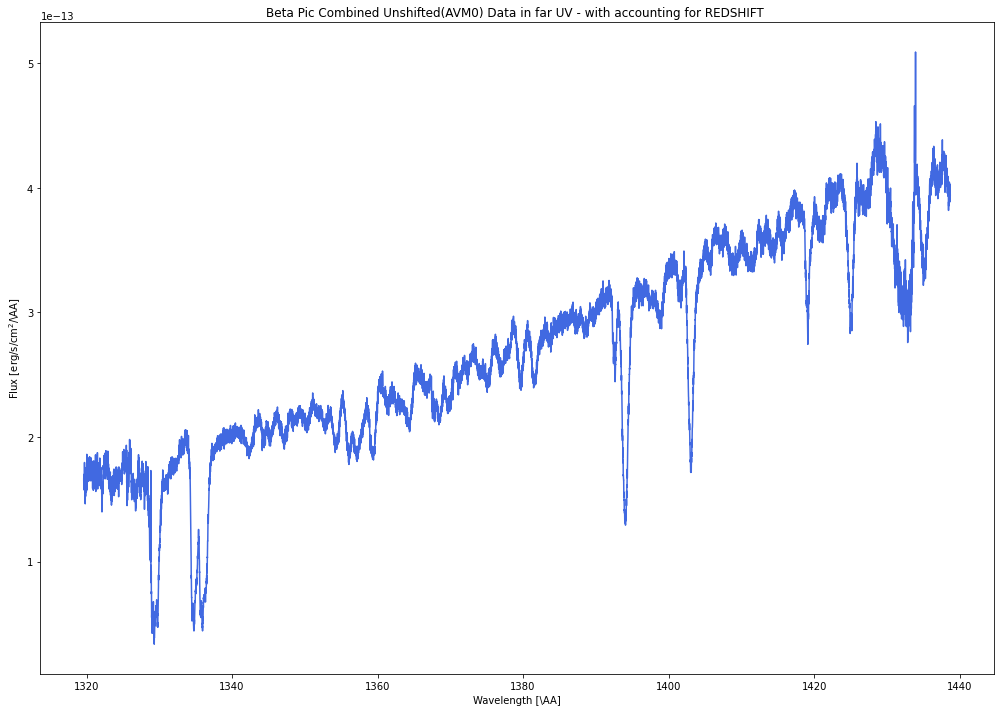

In [43]:
# Plotting the spectrum with the shifted wavelengths 

fig = plt.figure(figsize=(14.0,10.0))

# Normalised weighted average by shifted wavelengths
plt.plot(w_shifted, d0_n_w_ave , color = "royalblue")
plt.title("Beta Pic Combined Unshifted(AVM0) Data in far UV - with accounting for REDSHIFT ")
plt.xlabel(r'Wavelength [\AA]')
plt.ylabel(r'Flux [erg/s/cm$^2$/\AA]')
fig.tight_layout()


Objective 3 certainly complete. I can now change the wavelength reigon as I like (I would predict that should be more accurate than just loading the whole spectrum and zooming in if I were to focus on a small reigon as it will give me better weighted averages).     


Viewing this larger scale one I immediately spotted the (C II) double at 1334-1336 that was in the "The Star-grazing Bodies in the HD 172555" paper that you sent. (https://iopscience.iop.org/article/10.3847/1538-3881/aabe74/pdf). It was encouraging to see and I understand much better why you suggested it as a place of interest.